In [1]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
import itertools
from copy import deepcopy

Populating the interactive namespace from numpy and matplotlib


In [2]:
m1 = (vsr.Vec(1,2,3).unit() * 0.1 ).trs() * vsr.Rot(vsr.Biv(1,2,10).unit() * 0.2)
m2 = (vsr.Vec(-1,2,3).unit() * 1000 ).trs() * vsr.Rot(vsr.Biv(1,2,10).unit() * (-pi))

In [3]:
m1

Mot: [ 0.98 -0.019 -0.039 -0.19 -0.015 -0.034 -0.034 0.0023 ]

In [470]:
def generate_pointcloud_and_normals(n_samples, motor):
    
    bunny_xyz_file = 'point_clouds/THINGY2_cloud_0010.txt'
    f = open(bunny_xyz_file)
    data_points = np.loadtxt(bunny_xyz_file, usecols=(0,1,2))
    data_normals = np.loadtxt(bunny_xyz_file, usecols=(3,4,5))  
    f.close()
    print(data_points.size)
    print(*data_normals[3])
    #n_samples = data_points.size
    print('f')
    sigma = 0.3
    points = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() for i in range(n_samples)]
    normals = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).unit() for i in range(n_samples)]
    
    print(vsr.Vec(*data_points[1]).null())
    points = [vsr.Vec(*data_points[i]).null() for i in range(n_samples)]
    normals = [vsr.Vec(*data_normals[i]).unit() for i in range(n_samples)]
    
    lines = [vsr.Dll(point, normal) for point, normal in zip(points, normals)]
    samples_1 = [(point, lines) for point, lines in zip(points, lines)]
    samples_2 = [(point.spin(motor), line.spin(motor)) for point, line in samples_1]
    
    points_noisy = [vsr.Vec(*(np.array(p)[:3] + sigma * np.random.randn(3))).null().spin(motor) 
                    for p in points]
    normals_noisy = [n.spin((vsr.Biv(*np.random.random(3)).unit() * np.random.random(1) * 0.7).exp()) 
                     for n in normals]
    lines_noisy = [vsr.Dll(point, normal)
                   for point, normal in zip(points_noisy, normals_noisy)]
    samples_3 = [(point, lines) for point, lines in zip(points_noisy, lines_noisy)]       
    return (samples_1, samples_2, samples_3)

In [471]:
A,B,C = generate_pointcloud_and_normals(10000,m1)
print(len(A))

522555
-0.878212 0.243865 -0.411428
f
Pnt: [ -0.02845 -0.03308 0.7468 1 0.2798 ]
10000


In [472]:
print(np.sum([np.array(p.vec()) for p,_ in B]))
Acp = vsr.Vec(*(np.sum([np.array(p.vec()) for p,_ in A],axis=0) / len(A))).null()
Acl = vsr.Dll(*(np.sum([np.array(l) for _,l in A],axis=0) / len(A)))
Bcp = vsr.Vec(*(np.sum([np.array(p.vec()) for p,_ in B],axis=0) / len(B))).null()
Bcl = vsr.Dll(*(np.sum([np.array(l) for _,l in B],axis=0) / len(B)))
Ccp = vsr.Vec(*(np.sum([np.array(p.vec()) for p,_ in C],axis=0) / len(C))).null()
Ccl = vsr.Dll(*(np.sum([np.array(l) for _,l in C],axis=0) / len(C)))

4553.99451073


In [473]:
print(Bcp)
print(Ccp)
print(Acl)
print(Bcl)
print(Ccl)

Pnt: [ -0.04743 -0.2538 0.7567 1 0.3196 ]
Pnt: [ -0.04403 -0.2543 0.754 1 0.3176 ]
Dll: [ -0.5201 -0.2542 -0.705 -0.183 -0.5374 -0.02438 ]
Dll: [ -0.4421 -0.4172 -0.6803 -0.2092 -0.5342 -0.1937 ]
Dll: [ -0.6256 -0.2303 -0.5357 -0.02102 -0.4305 -0.1448 ]


In [474]:
Ccl.biv().duale() <= Ccl.drv().vec()

0.0027060126251874095

In [475]:
Bcl.biv().duale() <= Bcl.drv().vec()

0.005058286915212651

In [476]:
A[0][1].biv().duale() <= A[0][1].drv().vec()

2.949029909160572e-17

In [477]:
mes = MotorEstimationSolver(m2)
mes.add_point_correspondences_residual_block(Acp, Bcp)
#mes.add_line_angle_distance_residual_block(Acl, Bcl)
#mes.add_line_commutator_residual_block(Acl, Bcl)
mes.add_line_correspondences_residual_block(Acl, Bcl)

# mes.max_num_iterations = 5
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(motor, summary, _) = mes.solve()
print(m1)
print(motor)
print(summary['full_report'])

Mot: [ 0.98 -0.019 -0.039 -0.19 -0.015 -0.034 -0.034 0.0023 ]
Mot: [ -0.98 0.019 0.039 0.19 0.015 0.034 0.034 -0.0023 ]

Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                             2                        2
Residual                                    9                        9

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Line

In [478]:
np.allclose(m1, motor*-1,rtol=1e-3)

True

In [479]:
m1

Mot: [ 0.98 -0.019 -0.039 -0.19 -0.015 -0.034 -0.034 0.0023 ]

In [480]:
motor*-1

Mot: [ 0.98 -0.019 -0.039 -0.19 -0.015 -0.034 -0.034 0.0023 ]

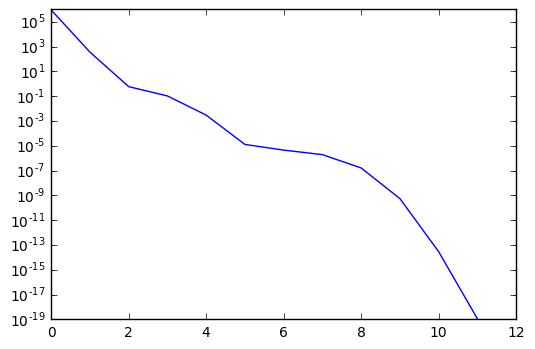

In [481]:
semilogy([it['cost'] for it in summary['iterations']])

In [482]:
np.linalg.norm(m1 * motor.rev())

1.000000000000004

In [484]:
moved_samples1 = [x.spin(motor) for (x,l) in A]
d = 0
for i in range(len(moved_samples1)):
    d = d + (moved_samples1[i] <= B[i][0])
    
import math
print(math.sqrt(d/len(moved_samples1)))

6.985291828712358e-09


In [209]:
l1 = vsr.Dll(vsr.Vec(0,0,1).null(), vsr.Vec(1,0,0))
l2 = vsr.Dll(vsr.Vec(1,0,0).null(), vsr.Vec(0,1,0))
l3 = vsr.Dll(vsr.Vec(0,1,0).null(), vsr.Vec(0,0,1))

In [100]:
l1mesh = line_mesh(l1, color='red')
l2mesh = line_mesh(l2, color='green')
l3mesh = line_mesh(l3, color='blue')

S1 = line_mesh((l1 + l2)*0.5, color='yellow')
S2 = line_mesh(((l1 +l2 + l3) * (1/3) ),color='purple')

ls = [l1mesh, l2mesh, l3mesh, S1, S2]
scene = Scene(children=[frame_mesh(), AmbientLight(color='#777777')] + ls)

camera = PerspectiveCamera(position=[0, 5, 5], up=[0, 0, 1],
                      children=[DirectionalLight(color='white', 
                                                 position=[3, 5, 1], 
                                                 intensity=0.5)])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
renderer.width = '950'
renderer.height = '713'
display(renderer)

In [275]:
l1 + l2

Dll: [ 0 -1 1 0 1 1 ]

In [280]:
vsr.Vec(0,0,0).null().spin(((l1 + l2 + l3) * -0.5).exp())

Dls: [ 1 1 1 1 1.5 ]

In [281]:
vsr.Vec(1,1,1).null()

Pnt: [ 1 1 1 1 1.5 ]